In [1]:
from pyomo.environ import *
import numpy as np
import matplotlib.pyplot as plt
import bisect
from pyomo.opt import SolverStatus, TerminationCondition

In [2]:
mmm = 0

In [37]:
def evaluate_Q_at(model, y_val, solver):
    """
    Given y = y_val , minimize obj_expr and return v(y).
    This function temporarily increments the objective and clears it after completion, without changing the model structure.
    """
    # Clear any remaining As/pw/obj (to prevent it from being left over from the previous round)
    for comp in ['obj', 'As', 'pw']:
        if hasattr(model, comp):
            model.del_component(comp)

    # Fix y, create a temporary target and solve
    model.y.fix(y_val)
    model.obj = Objective(expr=model.obj_expr, sense=minimize)
    results = solver.solve(model, tee=False)

    status_ok = (results.solver.status == SolverStatus.ok)
    term_ok = (results.solver.termination_condition == TerminationCondition.optimal)
    if not (status_ok and term_ok):
        # check if solution okay
        raise RuntimeError(f"Scenario evaluate at y={y_val} not optimal: "
                           f"status={results.solver.status}, term={results.solver.termination_condition}")

    v_y = value(model.obj_expr)
    # clear temporarily objective
    model.del_component('obj')
    model.y.unfix()
    return v_y

def nc_underest(bounds, model_list, add_node_num, tolerance=1e-8):
    """
    Parameters:
        bounds (list): contains 2 float which is lower and upper bound of variable
        model (list): model with submodels corresponds to each scenario
        add_node_num (float): number of sample nodes
        tolerance (float): decide when to stop

    Returns: delta (float): delta
             errors (float): hausdorff error
             y_nodes (list): y node (to make plot)
             as_nodes_list[0] (list): As node value (to make plot)
             ms_list[0] (float): ms for first scenario (to make plot)
    """
    N = len(model_list) 
    new_lb = bounds[0]
    new_ub = bounds[1]
    eff_node_count = 0 #  count how many extra nodes were actually added
    as_nodes_list = [None] * N
    ms_list = [None] * N
    new_nodes_list = [None] * N
    active = [True] * N  # check if this scenario has been optimized
    under_tol = 1e-8

    # set up solver
    solver = SolverFactory('gurobi')
    solver.options['FeasibilityTol'] = 1e-9
    solver.options['OptimalityTol'] = 1e-9
    solver.options['NonConvex'] = 2 
    
    # start with 2 nodes
    #y_nodes = bounds
    y_nodes = [bounds[0],bounds[1]]
    for i in range(N):
        as_nodes_list[i] = [evaluate_Q_at(model_list[i], new_lb, solver),evaluate_Q_at(model_list[i], new_ub, solver)]
        #as_nodes_list[i] = [evaluate_Q_at(model_list[i], new_lb, solver),evaluate_Q_at(model_list[i], 0, solver),evaluate_Q_at(model_list[i], new_ub, solver)]
 
    # reset bounds
    for i in range(N):
        model_list[i].y.setlb(new_lb)
        model_list[i].y.setub(new_ub)
    
    print('start')
    for k in range(2,add_node_num+1):
        print('Adding node ',k)
        for i in range(N):
            
            if not active[i]:
                continue  #this scenario has been optimized
                
            print('Solving scenario ',i)
            # define piecewise function for each scenario
            for comp in ['obj', 'As', 'pw']:
                if hasattr(model_list[i], comp):
                    model_list[i].del_component(comp)
            model_list[i].As = Var()
            model_list[i].pw = Piecewise(
                model_list[i].As, model_list[i].y,
                pw_pts=y_nodes,
                f_rule=as_nodes_list[i],
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )

            # set ip objective for each scenario and solve
            model_list[i].obj = Objective(expr=model_list[i].obj_expr - model_list[i].As, sense=minimize)
            results = solver.solve(model_list[i])
            
            if (results.solver.status != SolverStatus.ok) or \
               (results.solver.termination_condition != TerminationCondition.optimal):
                print("⚠ There may be problems with the solution")
                
            ms_list[i] = value(model_list[i].obj)
            if ms_list[i] >= -under_tol:
                active[i] = False

                
            # insert new nodes
            new_nodes_list[i] = value(model_list[i].y)
            
            
            
        ##################################################
                    
        # define and solve the sum model
        assum_nodes = np.sum(as_nodes_list, axis=0)
        if (k == 2) and (abs(assum_nodes[0] - assum_nodes[1]) <= 1e-12):
            y_star = 0.5*(y_nodes[0] + y_nodes[1])
            bbb = 0
            for i in range(N):
                bbb += evaluate_Q_at(model_list[i], y_star, solver)
            if bbb <= assum_nodes[0]:
                errors = bbb
            else:
                
        else:
            model_sum = ConcreteModel()
            model_sum.y = Var(bounds=(new_lb, new_ub))
            model_sum.As = Var()
            model_sum.pw = Piecewise(
                model_sum.As, model_sum.y,
                pw_pts=y_nodes,
                f_rule=list(assum_nodes),
                pw_constr_type='EQ',
                pw_repn='SOS2'
            )
            model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
            results = solver.solve(model_sum,tee=True)
            if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
                pass
            else:
                print("Sum model doesn't get solved normally")
            # get the output
            errors = results.problem.lower_bound + sum(ms_list)
            y_star = value(model_sum.y)
        aaa = 0
        for i in range(N):
            aaa += evaluate_Q_at(model_list[i], y_star, solver)
        errors = aaa - errors
        
        sum_ms = abs(sum(ms_i for ms_i in ms_list))
        
        print(' ')
        print(' ')
        print('error is ',errors)
        print('ms is ',ms_list,sum_ms)
        if errors > sum_ms:
            new_node = y_star
            print(' ')
            print(' ')
            print('new node choosen from error')
            print(' ')
        else:
            min_index = np.argmin(ms_list)
            new_node = new_nodes_list[min_index]
            print(' ')
            print(' ')
            print('new node choosen from ms')
            print(' ')

        #######################################################              
 
        
        
        
        
        
        
        
        

        
        '''
        # check if new node is too close to old nodes         
        if (k == 3):
            last_node = new_node
        else:
            if (abs(new_nodes_list[i] - value(model_list[i].y)) <= 1e-6):
                print("The new node is too close and not inserted")
            break
        '''

        if (new_node not in y_nodes) and (k != add_node_num):
            idx = bisect.bisect_left(y_nodes, new_node)
            y_nodes.insert(idx, new_node)
            for i in range(N):
                as_nodes_list[i].insert(idx, evaluate_Q_at(model_list[i], new_node, solver))
            eff_node_count += 1
            
        print('ms list')
        print(ms_list)
                
        if not any(active):
            print("[stop] all scenario is underestimator")
            print("Add ",k," nodes")
            break

    # define and solve the sum model
    assum_nodes = np.sum(as_nodes_list, axis=0)
    model_sum = ConcreteModel()
    model_sum.y = Var(bounds=(new_lb, new_ub))
    model_sum.As = Var()
    model_sum.pw = Piecewise(
        model_sum.As, model_sum.y,
        pw_pts=y_nodes,
        f_rule=list(assum_nodes),
        pw_constr_type='EQ',
        pw_repn='SOS2'
    )
    model_sum.obj = Objective(expr = model_sum.As, sense=minimize)
    results = solver.solve(model_sum)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        pass
    else:
        print("Sum model doesn't get solved normally")
    # get the output
    errors = results.problem.lower_bound + sum(ms_list)
    errors = mmm-errors
    
    # calculate the diameter
    delta = (new_ub-new_lb)/2
    
    #return delta, errors, y_nodes, as_nodes_list[0], ms_list[0], as_nodes_list[1], ms_list[1], eff_node_count, min_index,new_node
    return delta, errors, y_nodes, as_nodes_list[0], ms_list[0], as_nodes_list[1], ms_list[1], eff_node_count,new_node

In [38]:
# build function for each scenario
def v_1(y):  
    return - np.sqrt(np.abs(y))

def v_2(y): 
    return np.sqrt(np.abs(y))

v_list = [v_1, v_2]

# build model for each scenario 
m1 = ConcreteModel()
m1.y = Var(bounds=(-1, 1))
m1.x1 = Var(bounds=(0, 1))
m1.x11 = Var(bounds=(0, None))
m1.c1 = Constraint(expr=m1.x11**2 == m1.y**2)
m1.c2 = Constraint(expr=m1.x11 == (m1.x1)**2)
m1.obj_expr = Expression(expr=-m1.x1)

m2 = ConcreteModel()
m2.y = Var(bounds=(-1, 1))
m2.x2 = Var(bounds=(0, 1))
m2.c1 = Constraint(expr=m2.x2**2 >= m2.y)
m2.c2 = Constraint(expr=m2.x2**2 >= -m2.y)
m2.obj_expr = Expression(expr=m2.x2)

model_list = [m1, m2]
# lower bound and upper bound
ylb = -0.2
yub = 0.2
bounds = [ylb, yub]

In [39]:
# make delta list
adds = np.arange(3, 5)
results = [nc_underest([ylb, yub],[m1,m2],a) for a in adds]

start
Adding node  2
Solving scenario  0
Solving scenario  1


UnboundLocalError: local variable 'errors' referenced before assignment

   
   
   
y node is  [-0.2  0.   0.2]
y node length 3
ms value is  [-0.11180340533848798, -8.166172182910714e-10]
new_nodes is  -0.04998092776511266
this time choose scenario  0


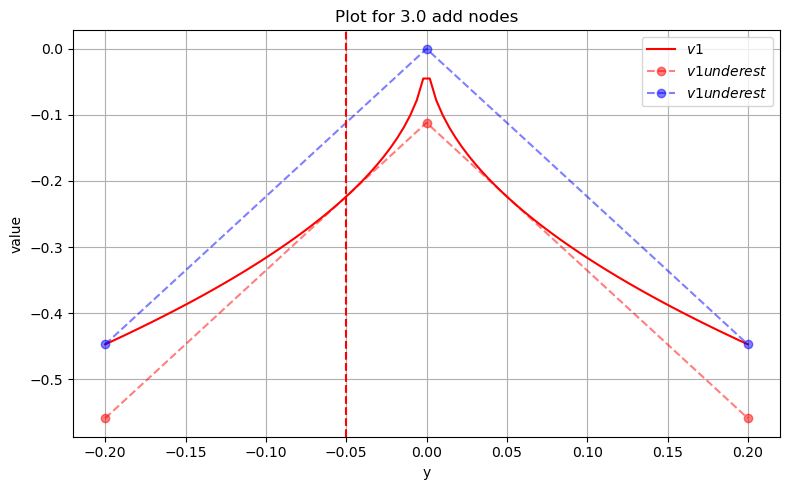

   
   
   
y node is  [-0.2        -0.04998093  0.          0.2       ]
y node length 4
ms value is  [-0.1118033669886418, -8.166172182910714e-10]
new_nodes is  0.04994661012497079
this time choose scenario  1


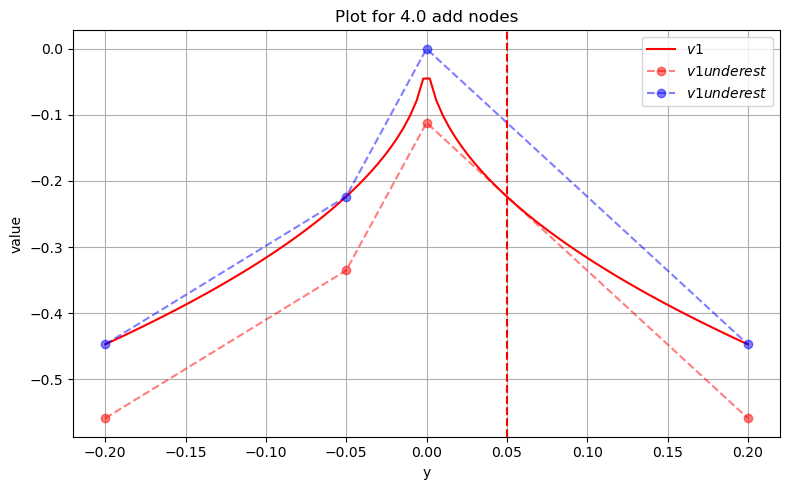

In [27]:
for i in range(len(results)):
    # y and z = |y|
    y_vals = np.linspace(ylb, yub, 100)
    Qs_vals1 = [v_list[0](y) for y in y_vals]
    Qs_vals2 = [v_list[1](y) for y in y_vals]
    Qs_vals_sum = [v_list[0](y)+v_list[1](y) for y in y_vals]

    # As(y)
    y_nodes = np.array(results[i][2])
    as_nodes1 = np.array(results[i][3])
    as_nodes2 = np.array(results[i][5])
    bbb1 = np.array(as_nodes1)
    bbb2 = np.array(as_nodes2)
    bbb_sum = bbb1+bbb2
    ms1 = results[i][4]
    ms2 = results[i][6]
    #err = -results[i][1]
    err = ms1+ms2
    
    print("   ")
    print("   ")
    print("   ")
    #print('effective add node num ',results[i][-2])
    print('y node is ',y_nodes)
    print('y node length',len(y_nodes))
    print("ms value is ",[results[i][4],results[i][6]])
    print("new_nodes is ",results[i][-1])
    print("this time choose scenario ",results[i][-2])

    # make the plot
    
    plt.figure(figsize=(8, 5))
    
    plt.plot(y_vals, Qs_vals1, label=r'$v1$', color='red')
    plt.plot(y_nodes, bbb1+ms1,label=r'$v1 underest$',color='red', marker='o',linestyle='--',alpha=0.5)
    plt.plot(y_nodes, bbb1,label=r'$v1 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    '''
    plt.plot(y_vals, Qs_vals2, label=r'$v2$', color='blue')
    plt.plot(y_nodes, bbb2+ms2,label=r'$v2 underest$',color='blue', marker='o',linestyle='--',alpha=0.5)
    
    plt.plot(y_vals, Qs_vals_sum, label=r'$v_sum$', color='black')
    plt.plot(y_nodes, bbb_sum+err,label=r'$v_sum underest$',color='black', marker='o',linestyle='--',alpha=0.5)
    '''
    plt.axvline(x=results[i][-1], color='red', linestyle='--')
    #plt.hlines(y=mmm, xmin=ylb, xmax=yub,color='red', linestyle='--')
    
    #plt.xlim(0.05, 0.125)
    #plt.ylim(-0.4, -0.2)
    plt.xlabel('y')
    plt.ylabel('value')
    plt.title(f"Plot for {adds[i]:.1f} add nodes")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()